# IMPORTS

In [153]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# DATA LOADING

In [154]:
DATA_RUTE = r"data/"

MOVIES = pd.read_csv(f"{DATA_RUTE}TMDB_movie_dataset_v11.csv")

In [155]:
MOVIES.columns

Index(['id', 'title', 'vote_average', 'vote_count', 'status', 'release_date',
       'revenue', 'runtime', 'adult', 'backdrop_path', 'budget', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'tagline', 'genres',
       'production_companies', 'production_countries', 'spoken_languages',
       'keywords'],
      dtype='object')

In [156]:
MOVIES = MOVIES.drop(columns=["homepage", "poster_path", "backdrop_path"])
MOVIES.head()

,id,title,vote_average,vote_count,status,release_date,revenue,runtime,adult,budget,...,original_language,original_title,overview,popularity,tagline,genres,production_companies,production_countries,spoken_languages,keywords
0,27205,Inception,8.364,34495,Released,2010-07-15,825532764,148,False,160000000,...,en,Inception,"Cobb, a skilled thief who commits corporate es...",83.952,Your mind is the scene of the crime.,"Action, Science Fiction, Adventure","Legendary Pictures, Syncopy, Warner Bros. Pict...","United Kingdom, United States of America","English, French, Japanese, Swahili","rescue, mission, dream, airplane, paris, franc..."
1,157336,Interstellar,8.417,32571,Released,2014-11-05,701729206,169,False,165000000,...,en,Interstellar,The adventures of a group of explorers who mak...,140.241,Mankind was born on Earth. It was never meant ...,"Adventure, Drama, Science Fiction","Legendary Pictures, Syncopy, Lynda Obst Produc...","United Kingdom, United States of America",English,"rescue, future, spacecraft, race against time,..."
2,155,The Dark Knight,8.512,30619,Released,2008-07-16,1004558444,152,False,185000000,...,en,The Dark Knight,Batman raises the stakes in his war on crime. ...,130.643,Welcome to a world without rules.,"Drama, Action, Crime, Thriller","DC Comics, Legendary Pictures, Syncopy, Isobel...","United Kingdom, United States of America","English, Mandarin","joker, sadism, chaos, secret identity, crime f..."
3,19995,Avatar,7.573,29815,Released,2009-12-15,2923706026,162,False,237000000,...,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",79.932,Enter the world of Pandora.,"Action, Adventure, Fantasy, Science Fiction","Dune Entertainment, Lightstorm Entertainment, ...","United States of America, United Kingdom","English, Spanish","future, society, culture clash, space travel, ..."
4,24428,The Avengers,7.710,29166,Released,2012-04-25,1518815515,143,False,220000000,...,en,The Avengers,When an unexpected enemy emerges and threatens...,98.082,Some assembly required.,"Science Fiction, Action, Adventure",Marvel Studios,United States of America,"English, Hindi, Russian","new york city, superhero, shield, based on com..."


# DATA WRANGLING

- NANs
- Non sense values
  ...

### Release date to year

In [157]:
MOVIES["release_year"] = pd.to_datetime(MOVIES['release_date']).dt.year
MOVIES["release_year"] = MOVIES["release_year"].fillna(0).astype(int)
MOVIES["release_year"]


0          2010
1          2014
2          2008
3          2009
4          2012
           ... 
1128262    2016
1128263    2012
1128264    2018
1128265    2014
1128266    2024
Name: release_year, Length: 1128267, dtype: int64

### Remove outliers, wrong values and NaNs from years

In [158]:
FIRST_MOVIE_YEAR = 1888
ACTUAL_YEAR = 2024
MOVIES = MOVIES[MOVIES["status"] == "Released"]
MOVIES = MOVIES[(MOVIES["release_year"] >= FIRST_MOVIE_YEAR) & (MOVIES["release_year"] <= ACTUAL_YEAR) & (MOVIES["release_year"] != 0)]


print(f"Fist year: {MOVIES["release_year"].min()}, Last year: {MOVIES["release_year"].max()}")

Fist year: 1888, Last year: 2024


# Data analysis

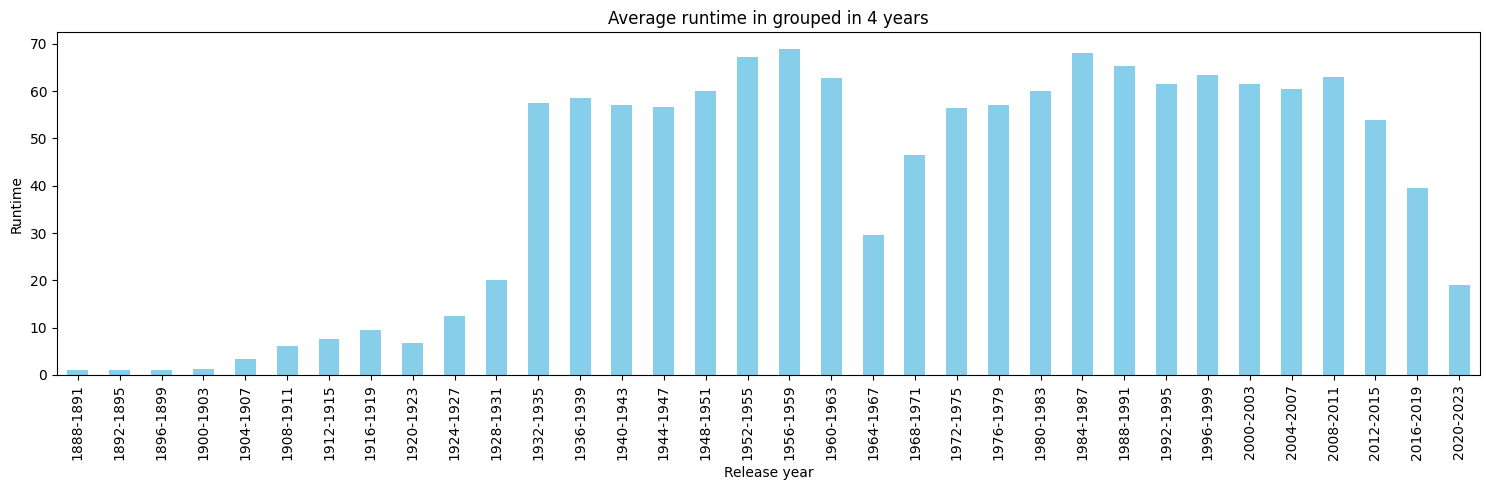

In [159]:
movies_year_runtime = MOVIES.groupby("release_year")["runtime"].median()

bin_size = 4

binned_counts = {}
for i in range(FIRST_MOVIE_YEAR, movies_year_runtime.index.max(), bin_size):
    bin_start, bin_end = i, i + bin_size - 1
    
    # Sum all the runtimes counts in this range.
    total_in_bin = movies_year_runtime[(movies_year_runtime.index >= bin_start) & (movies_year_runtime.index <= bin_end)].median()
    
    binned_counts[f'{bin_start}-{bin_end}'] = total_in_bin


binned_token_counts = pd.Series(binned_counts)

plt.figure(figsize=(15, 5))
binned_token_counts.plot(kind='bar', color='skyblue')

plt.xlabel('Release year')
plt.ylabel('Runtime')
plt.title(f'Average runtime in grouped in {bin_size} years')

plt.tight_layout()

['Romance', 'Music', 'Science Fiction', 'Drama', 'Horror', 'Crime', 'Action', 'TV Movie', 'Animation', 'History', 'Mystery', 'Documentary', 'Fantasy', 'War', 'Western', 'Thriller', 'Family', 'Comedy', 'Adventure']


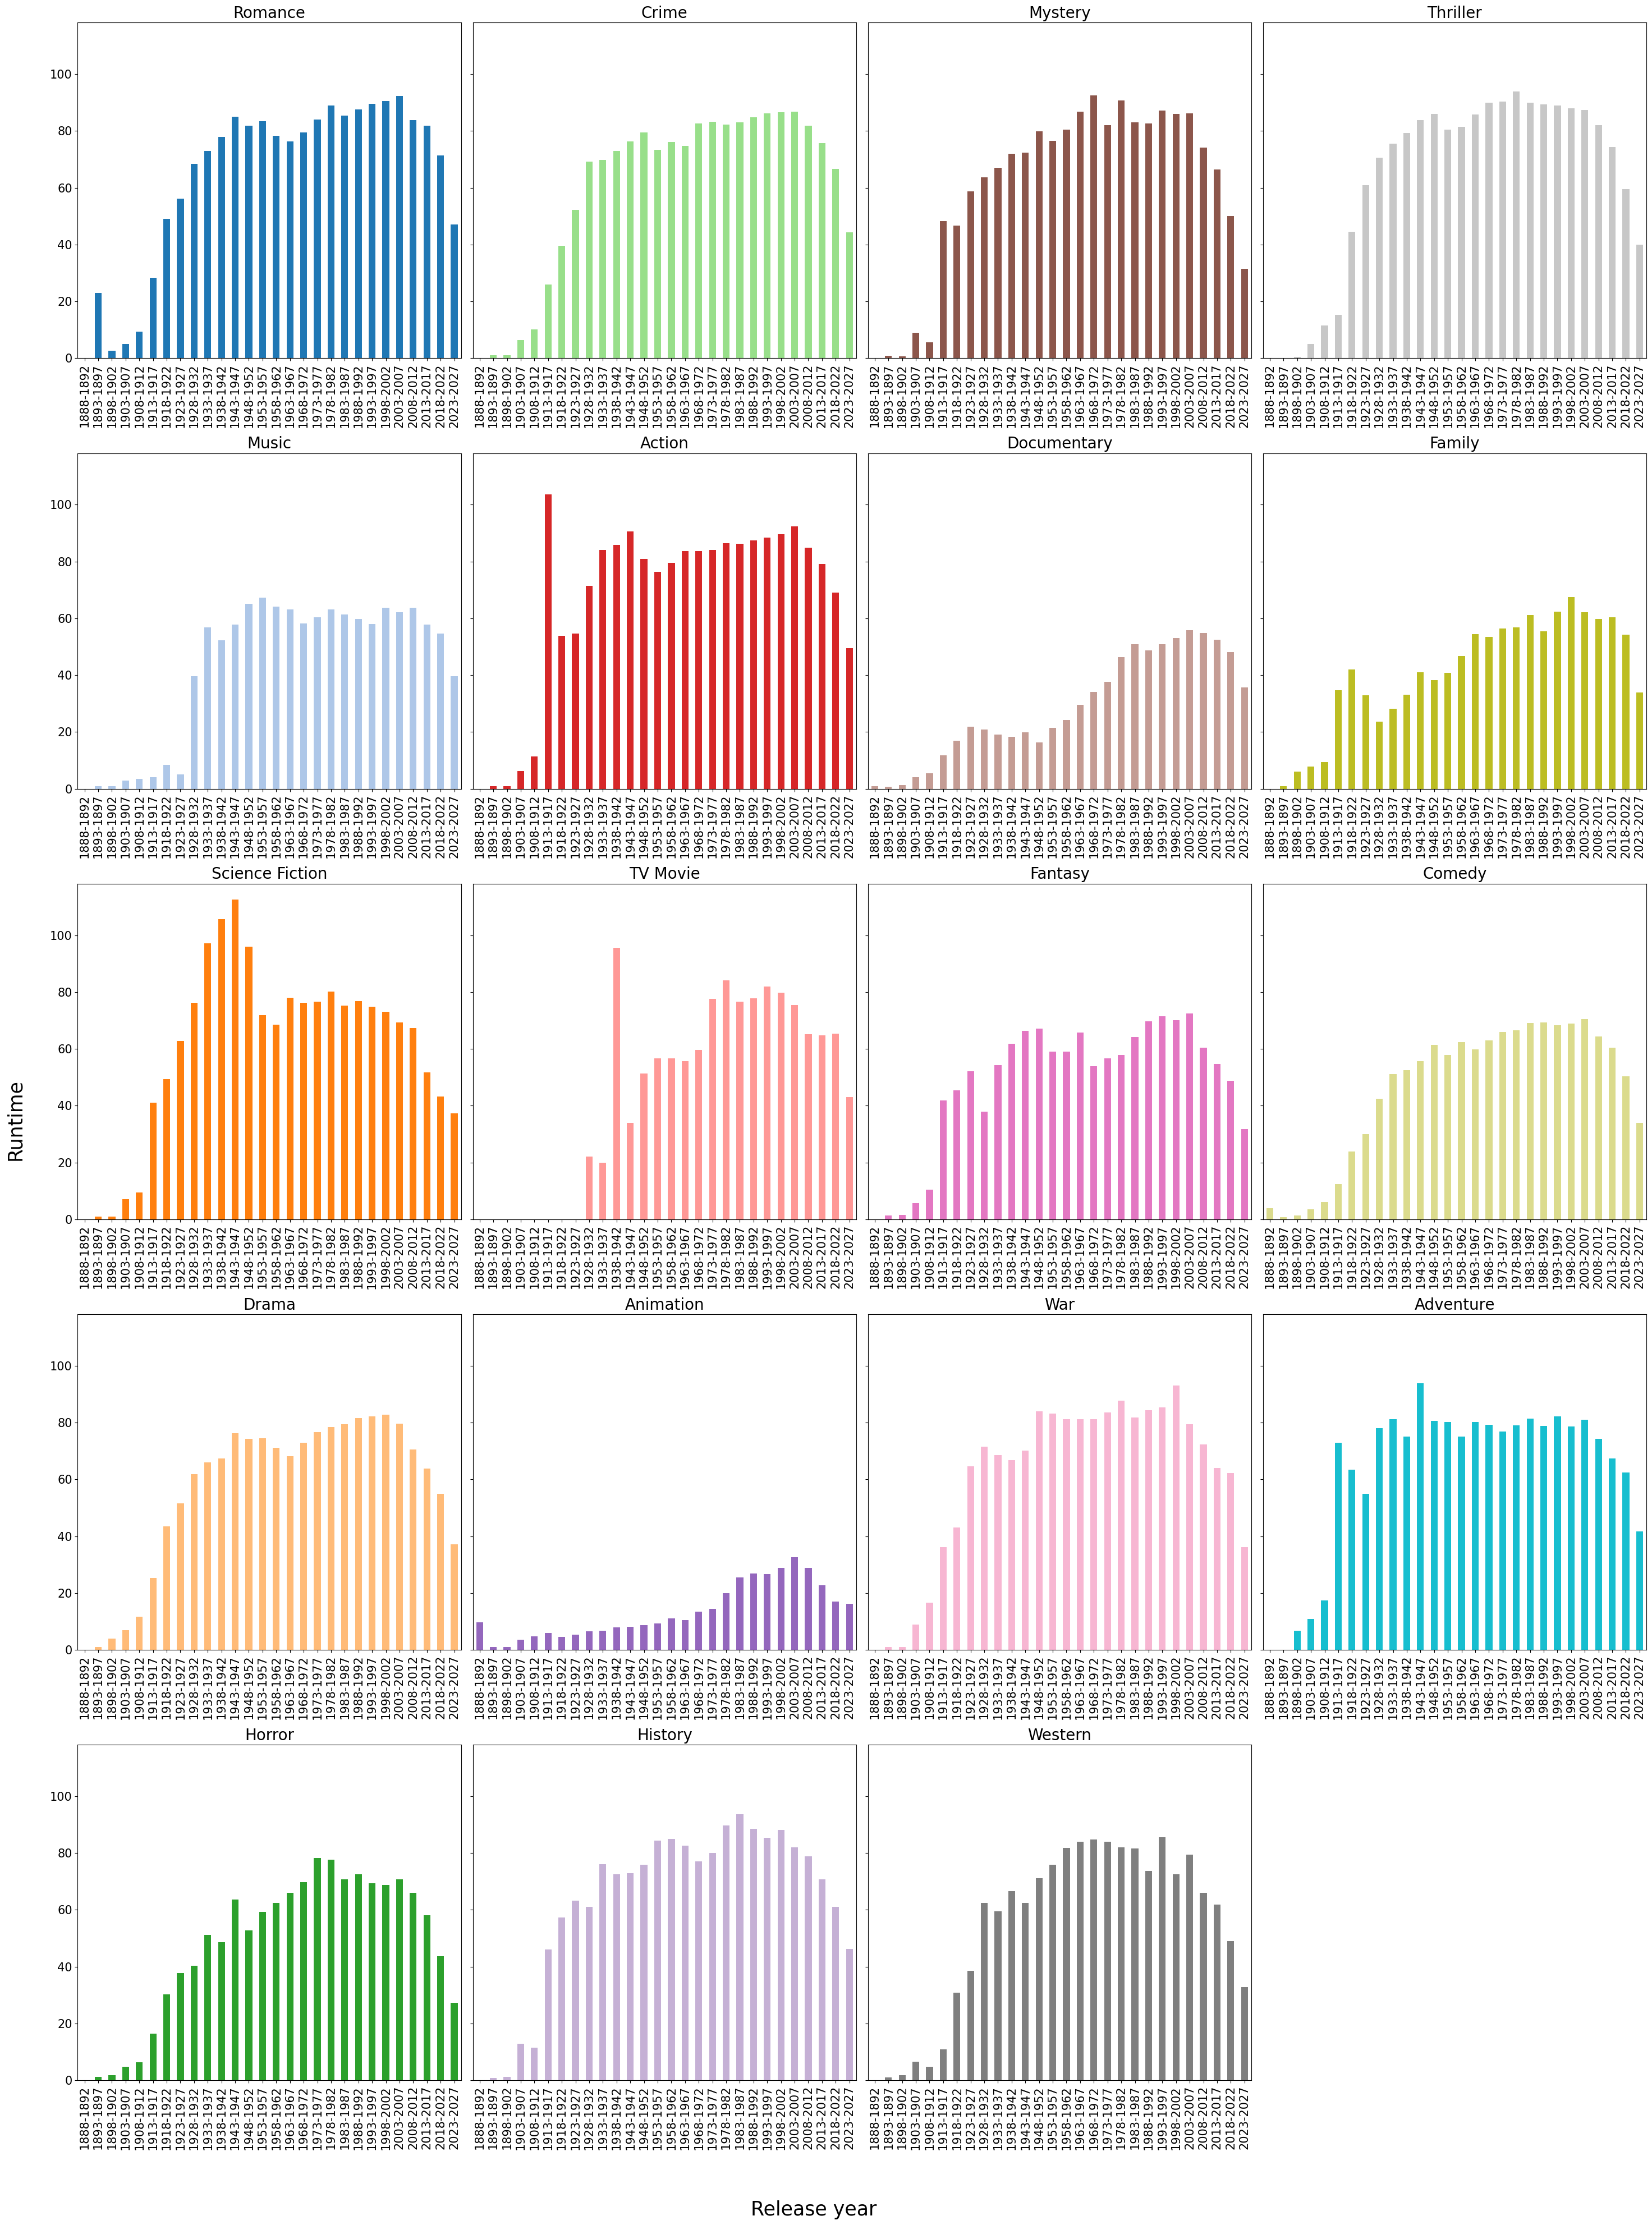

In [162]:
import seaborn as sns
unique_genre = set()
MOVIES["genres"].astype(str).str.split(", ").apply(unique_genre.update)
unique_genre.remove('nan')
unique_genre = list(unique_genre)
print(unique_genre)

fig, axes = plt.subplots(5, 4, figsize=(30, 40), sharey = True)
fig.delaxes(axes[4, 3])
colors = sns.color_palette("tab20", len(unique_genre))
color_iter = iter(colors)

for j in range(len(unique_genre)):

    filtered_df = MOVIES[MOVIES["genres"].astype(str).str.contains(unique_genre[j])]
    bin_size = 5
    movies_year_runtime = filtered_df.groupby("release_year")["runtime"].mean()
    binned_counts = {}
    for i in range(FIRST_MOVIE_YEAR, movies_year_runtime.index.max(), bin_size):
        bin_start, bin_end = i, i + bin_size - 1
        
        # Sum all the runtimes counts in this range.
        total_in_bin = movies_year_runtime[(movies_year_runtime.index >= bin_start) & (movies_year_runtime.index <= bin_end)].median()
        
        binned_counts[f'{bin_start}-{bin_end}'] = total_in_bin


    binned_token_counts = pd.Series(binned_counts)
    color = next(color_iter)
    ax = axes[j%5, j//5]
    binned_token_counts.plot(kind='bar', ax=ax, color=color, fontsize=15)

    ax.set_title(unique_genre[j], size = 20)
fig.supxlabel('Release year', size = 25)
fig.supylabel('Runtime', size = 25)
fig.tight_layout(rect=(0.025,0.025,1,1))